In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.distributions as distributions

import gym
import matplotlib.pyplot as plt
import numpy as np

In [2]:
env_id = "CartPole-v1"
train_env = gym.make(env_id)
test_env = gym.make(env_id)

In [3]:
seed = 42
train_env.seed(seed)
test_env.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed);

In [4]:
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout=0.5):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.fc1(x)
        x = torch.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [5]:
input_dim = train_env.observation_space.shape[0]
hidden_dim = 128
output_dim = train_env.action_space.n

policy = MLP(input_dim, hidden_dim, output_dim)

In [6]:
learning_rate = 0.01
optimizer = optim.Adam(policy.parameters(), lr=learning_rate)

In [7]:
def calculate_returns(rewards, gamma, normalize=True):
    returns = []
    running_reward = 0

    for r in reversed(rewards):
        running_reward = r + running_reward * gamma
        returns.insert(0, running_reward)

    returns = torch.tensor(returns)
    if normalize:
        returns = (returns - returns.mean()) / returns.std()
    
    return returns


def update_policy(returns, log_prob_actions, optimizer):
    returns = returns.detach()
    loss = -(returns * log_prob_actions).sum()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return loss.item()


def train(env, policy, optimizer, gamma):
    policy.train()
    log_prob_actions = []
    rewards = []
    done = False
    episode_reward = 0
    state = env.reset()

    while not done:
        state = torch.FloatTensor(state).unsqueeze(0)
        action_out = policy(state)
        action_prob = F.softmax(action_out, dim=-1)
        dist = distributions.Categorical(action_prob)
        action = dist.sample()
        log_prob_action = dist.log_prob(action)
        state, reward, done, _ = env.step(action.item())
        log_prob_actions.append(log_prob_action)
        rewards.append(reward)
        episode_reward += reward

    log_prob_actions = torch.cat(log_prob_actions)
    returns = calculate_returns(rewards, gamma)
    loss = update_policy(returns, log_prob_actions, optimizer)

    return (loss, episode_reward)


def evaluate(env, policy):
    policy.eval()
    done = False
    episode_reward = 0
    state = env.reset()

    while not done:
        state = torch.FloatTensor(state).unsqueeze(0)
        with torch.no_grad():
            action_out = policy(state)
            action_prob = F.softmax(action_out, dim=-1)
        action = torch.argmax(action_prob, dim=-1)
        state, reward, done, _ = env.step(action.item())
        episode_reward += reward

    return episode_reward

In [8]:
num_episodes = 500
gamma = 0.99
num_trials = 25
reward_threshold = train_env.spec.reward_threshold
print_interval = 10

train_rewards = []
test_rewards = []

for episode in range(1, num_episodes + 1):
    loss, train_reward = train(train_env, policy, optimizer, gamma)
    test_reward = evaluate(test_env, policy)
    train_rewards.append(train_reward)
    test_rewards.append(test_reward)

    mean_train_reward = np.mean(train_rewards[-num_trials:])
    mean_test_reward = np.mean(test_rewards[-num_trials:])

    if episode % print_interval == 0:
        print(f"Episode: {episode}, mean train reward: {mean_train_reward}, mean test reward: {mean_test_reward}")
    
    if mean_test_reward >= reward_threshold:
        print(f"The policy has reached reward threshold {reward_threshold} in {episode} episodes.")
        break

Episode: 10, mean train reward: 14.5, mean test reward: 9.7
Episode: 20, mean train reward: 14.85, mean test reward: 9.6
Episode: 30, mean train reward: 20.84, mean test reward: 26.0
Episode: 40, mean train reward: 27.84, mean test reward: 42.36
Episode: 50, mean train reward: 56.4, mean test reward: 159.16
Episode: 60, mean train reward: 110.84, mean test reward: 329.16
Episode: 70, mean train reward: 170.2, mean test reward: 475.0
The policy has reached reward threshold 475.0 in 70 episodes.


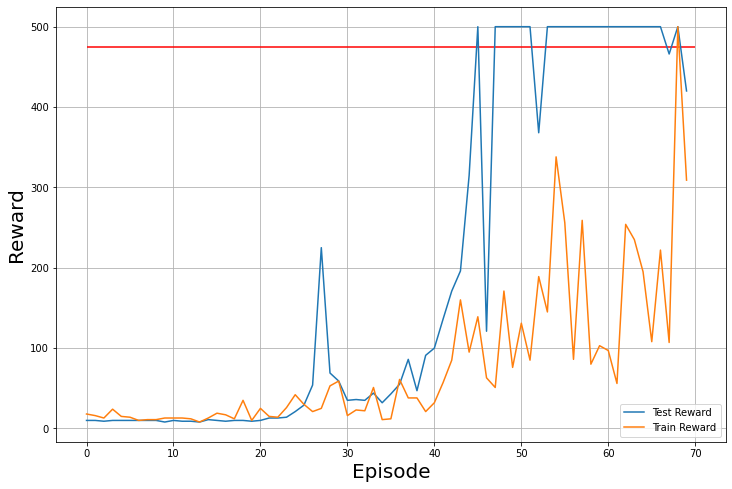

In [10]:
plt.figure(figsize=(12, 8))
plt.plot(test_rewards, label='Test Reward')
plt.plot(train_rewards, label='Train Reward')
plt.xlabel('Episode', fontsize=20)
plt.ylabel('Reward', fontsize=20)
plt.hlines(reward_threshold, 0, len(test_rewards), color='r')
plt.legend(loc='lower right')
plt.grid()